# 12th Ave collision data analyses

By Ethan C. Campbell for Central Seattle Greenways. Contact me at ethanchenbell@gmail.com with any questions.

*Note: Access to the StreetLight Data platform was provided thanks to a SPIN Mobility Data for Safer Streets grant to Seattle Neighborhood Greenways.*

## Preamble

In [ ]:
# Authorize access to Google Drive
from google.colab import drive, auth
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Install GeoPy (run once)
!pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Install Cartopy (run once)
!pip uninstall shapely --yes
!pip install shapely cartopy --no-binary shapely --no-binary cartopy

!wget https://raw.githubusercontent.com/SciTools/cartopy/master/tools/cartopy_feature_download.py
!python cartopy_feature_download.py physical  # have to manually download shapefiles
!python cartopy_feature_download.py cultural
!python cartopy_feature_download.py gshhs
!python cartopy_feature_download.py cultural-extra

In [ ]:
# Import packages
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from datetime import datetime, timedelta
from geopy.geocoders import MapBox
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

# MapBox API key
api_key = 'omitted - replace with your own'
geolocator = MapBox(api_key=api_key,timeout=3)

In [ ]:
# Filepaths
root = '/content/drive/MyDrive/CSG (Central Seattle Greenways) and ' + \
       'SNG (Seattle Neighborhood Greenways)/CSG 12th Ave Working Group/'
data_dir = root + 'Other data/'
stli_data_dir = root + 'StreetLight Data/'

wsdot_data_filepath = data_dir + '2023-03-01 - WSDOT collision data for 10th Ave, 12th Ave, Olive Way (2007-2023).xlsx'
prelim_data_filepath = data_dir + '2022-05-13 - 12th Ave SDOT bike and ped collisions (2016-2020) - from Stefanie Brendler.xlsx'
full_data_filepath = data_dir + '2022-08-21 - SDOT all collisions.csv'
export_data_filepath = data_dir + '2022-08-21 - all 12th Ave collisions from SDOT data set.csv'
export_bp_data_filepath = data_dir + '2022-08-21 - bike and ped 12th Ave collisions from SDOT data set.csv'
export_processed_data_filepath = data_dir + '2022-08-21 - 12th Ave segments - exported data.csv'

stli_bike_2021_filepath = stli_data_dir + '1092815_12th_Ave_Bike_January_October_2021_v2 - nondirectional (NB + SB)/' + \
                                          '1092815_12th_Ave_Bike_January_October_2021_za_bike.csv'
stli_bike_2019_filepath = stli_data_dir + '1092816_12th_Ave_Bike_2019_v2 - nondirectional (NB + SB)/' + \
                                          '1092816_12th_Ave_Bike_2019_v2_za_bike.csv'
stli_veh_2019_NB_filepath = stli_data_dir + '1078005_12th_Ave_NB_Segment_Analysis_2019/' + \
                                            '1078005_12th_Ave_NB_Segment_Analysis_2019_sa_all.csv'
stli_veh_2019_SB_filepath = stli_data_dir + '1077999_12th_Ave_SB_Segment_Analysis_2019/' + \
                                            '1077999_12th_Ave_SB_Segment_Analysis_2019_sa_all.csv'
stli_veh_2021_NB_filepath = stli_data_dir + '1078007_12th_Ave_NB_Segment_Analysis_2021/' + \
                                            '1078007_12th_Ave_NB_Segment_Analysis_2021_sa_all.csv'
stli_veh_2021_SB_filepath = stli_data_dir + '1078001_12th_Ave_SB_Segment_Analysis_2021/' + \
                                            '1078001_12th_Ave_SB_Segment_Analysis_2021_sa_all.csv'

wsdot_filepath = data_dir + '2022-08-22 - WSDOT Bicycle and Pedestrian Manual Counts.csv'

In [ ]:
# Process full WSDOT collision data set
wsdot_data = pd.read_excel(wsdot_data_filepath,sheet_name='Detailed Crash History',
                           skiprows=3,parse_dates=True)
wsdot_data = wsdot_data.loc[np.logical_or.reduce((wsdot_data['PRIMARY TRAFFICWAY'].astype(str).str.contains('12TH AVE'),
                                                  wsdot_data['INTERSECTING TRAFFICWAY'].astype(str).str.contains('12TH AVE'),
                                                  np.logical_and(wsdot_data['REFERENCE POINT NAME'].astype(str).str.contains('12TH AVE'),
                                                                 np.logical_or.reduce((wsdot_data['JUNCTION RELATIONSHIP'].astype(str).str.contains('At Intersection and Related'),
                                                                                       wsdot_data['JUNCTION RELATIONSHIP'].astype(str).str.contains('At Intersection and Not Related'),
                                                                                       wsdot_data['JUNCTION RELATIONSHIP'].astype(str).str.contains('Intersection Related but Not at Intersection'))))))]\
                                                                                       .reset_index()

In [ ]:
# Process full SDOT collision data set (run once, then ignore)
# SOURCE: https://data.seattle.gov/dataset/Collisions-All-Years/9jdj-3h57
full_data = pd.read_csv(full_data_filepath,parse_dates=True,low_memory=False)
full_data.loc[np.logical_and.reduce((full_data['LOCATION'].astype(str).str.contains('12TH AVE'),
                                    ~full_data['LOCATION'].astype(str).str.contains('12TH AVE NE'),
                                    ~full_data['LOCATION'].astype(str).str.contains('12TH AVE NW'),
                                    ~full_data['LOCATION'].astype(str).str.contains('12TH AVE SW'),
                                    full_data['LOCATION'].astype(str).str.startswith('12TH AVE')))]\
                                    .reset_index().to_csv(export_data_filepath)

In [ ]:
# Load curated SDOT collision data
data = pd.read_excel(prelim_data_filepath,parse_dates=True)
curated_data_incl_vehicles = pd.read_csv(export_data_filepath,parse_dates=['INCDATE','INCDTTM'])
sdot_data = curated_data_incl_vehicles  # alias for all SDOT collision data
curated_data = curated_data_incl_vehicles.loc[np.logical_or(curated_data_incl_vehicles['PEDCOUNT'] > 0,
                                                            curated_data_incl_vehicles['PEDCYLCOUNT'] > 0)].reset_index()
curated_data.to_csv(export_bp_data_filepath)

# Basic info on time period for SDOT data
collision_start_date = pd.Timestamp(sdot_data['INCDTTM'].min())
collision_end_date = pd.Timestamp(sdot_data['INCDTTM'].max())
print('SDOT collision data is from {0} to {1}'.format(collision_start_date.strftime('%b %Y'),collision_end_date.strftime('%b %Y')))

SDOT collision data is from Jan 2004 to Aug 2022


In [ ]:
# Load StreetLight output files
stli_bike_2019 = pd.read_csv(stli_bike_2019_filepath)
stli_bike_2021 = pd.read_csv(stli_bike_2021_filepath)
stli_veh_2019_NB = pd.read_csv(stli_veh_2019_NB_filepath)
stli_veh_2019_SB = pd.read_csv(stli_veh_2019_SB_filepath)
stli_veh_2021_NB = pd.read_csv(stli_veh_2021_NB_filepath)
stli_veh_2021_SB = pd.read_csv(stli_veh_2021_SB_filepath)

# Load WSDOT bike and ped manual counts
# Downloaded from: https://wsdot.wa.gov/data/tools/bikepedcounts/
wsdot_counts = pd.read_csv(wsdot_filepath,parse_dates=['CountDate'])

## Compare SDOT and WSDOT collision records

In [ ]:
sdot_year_counts = pd.to_datetime(sdot_data['INCDATE']).dt.year.value_counts().sort_index()
wsdot_year_counts = wsdot_data['DATE'].dt.year.value_counts().sort_index()

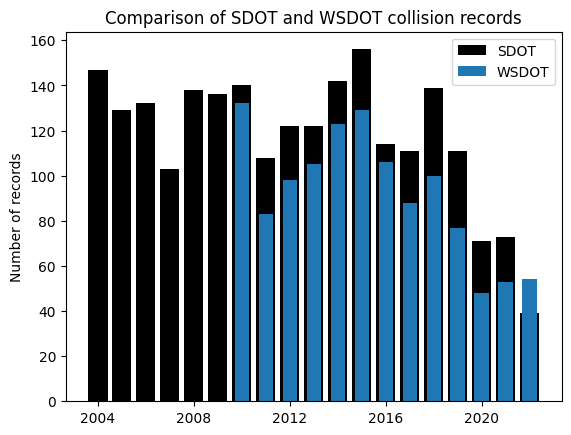

In [ ]:
plt.bar(sdot_year_counts.index,sdot_year_counts.values,width=0.8,color='k',label='SDOT')
plt.bar(wsdot_year_counts.index,wsdot_year_counts.values,width=0.6,label='WSDOT')
plt.xticks(np.arange(2004,2023,4))
plt.legend()
plt.ylabel('Number of records')
plt.title('Comparison of SDOT and WSDOT collision records');

## Establish corridor segments

In [ ]:
# Lookup table
street_dict_lowercase = {'Aloha':'E Aloha St',
                         'Roy':'E Roy St',
                         'Mercer':'E Mercer St',
                         'Republican':'E Republican St',
                         'Harrison':'E Harrison St',
                         'Thomas':'E Thomas St',
                         'John':'E John St',
                         'Denny':'E Denny Way',
                         'Howell':'E Howell St',
                         'Olive':'E Olive St',
                         'Pine':'E Pine St',
                         'Pike':'E Pike St',
                         'Union':'E Union St',
                         'Madison':'E Madison St',
                         'Spring':'E Spring St',
                         'Marion':'E Marion St',
                         'Columbia':'E Columbia St',
                         'Cherry':'E Cherry St',
                         'Jefferson':'E Jefferson St',
                         'Terrace':'E Terrace St',
                         'Alder':'E Alder St',
                         'Spruce':'E Spruce St',
                         'Fir':'E Fir St',
                         'Yesler':'E Yesler Way',
                         'Boren':'Boren Ave S',
                         'Main':'S Main St',
                         'Jackson':'S Jackson St',
                         'King':'S King St',
                         'Weller':'S Weller St',
                         'Charles':'S Charles S St'}
street_dict = street_dict_lowercase.copy()
for key in street_dict:
  street_dict[key] = street_dict[key].upper()

street_dict_correct = street_dict_lowercase.copy()
street_dict_correct['Charles'] = 'S Charles St'

In [ ]:
# Extract and clean up segment names
all_segments = stli_bike_2021['Zone Name'][stli_bike_2021['Zone Name'].str.contains('NB')]\
                .str.split(' - ',expand=True).drop_duplicates()
all_segments[1] = pd.to_numeric(all_segments[1])
all_segments.sort_values(1,inplace=True)
all_segments.drop(columns=[0,1],inplace=True)
all_segments.rename(columns={2:'Blocks'},inplace=True)
all_segments[['N street','S street']] = all_segments['Blocks'].str.split('-',expand=True)
all_segments['StreetLight zones (bike/ped)'] = stli_bike_2021['Zone Name'].loc[all_segments.index.values]
all_segments.reset_index(inplace=True)
all_segments.drop(columns=['index'],inplace=True)
all_segments['StreetLight zones (vehicle)'] = '12th Ave, ' + all_segments['Blocks']

# Nomenclature for 12th Ave
all_segments['12th Ave name (block)'] = ''
all_segments['12th Ave name (block)'].loc[0:6] = '12TH AVE E'
all_segments['12th Ave name (block)'].loc[7:21] = '12TH AVE'
all_segments['12th Ave name (block)'].loc[22:27] = '12TH AVE S'
all_segments['12th Ave name (N street)'] = ''
all_segments['12th Ave name (N street)'].loc[0:6] = '12TH AVE E'
all_segments['12th Ave name (N street)'].loc[7:22] = '12TH AVE'
all_segments['12th Ave name (N street)'].loc[23:27] = '12TH AVE S'

# Generate SDOT intersection and block names
all_segments['SDOT N intersection'] = all_segments['12th Ave name (N street)'] + \
  ' AND ' + np.array([street_dict[sn] for sn in all_segments['N street'].values])
for idx in all_segments.index:
  all_segments.loc[idx,'SDOT N intersection'] = [[all_segments.loc[idx,'SDOT N intersection']]]
all_segments['SDOT blocks'] = all_segments['12th Ave name (block)'] + \
  ' BETWEEN ' + np.array([street_dict[sn] for sn in all_segments['N street'].values]) + \
  ' AND ' + np.array([street_dict[sn] for sn in all_segments['S street'].values])
all_segments['SDOT blocks (reversed)'] = all_segments['12th Ave name (block)'] + \
  ' BETWEEN ' + np.array([street_dict[sn] for sn in all_segments['S street'].values]) + \
  ' AND ' + np.array([street_dict[sn] for sn in all_segments['N street'].values])
all_segments['SDOT blocks'] = all_segments[['SDOT blocks','SDOT blocks (reversed)']].values.tolist()
all_segments.drop(columns=['SDOT blocks (reversed)'],inplace=True)

# Add intermediate intersections within blocks
# Pike-Union
all_segments.loc[11,'SDOT blocks'].append('12TH AVE BETWEEN E PIKE ST AND E MADISON ST')
all_segments.loc[11,'SDOT blocks'].append('12TH AVE BETWEEN E MADISON ST AND E PIKE ST')
# Madison-Spring
all_segments.loc[12,'SDOT N intersection'].append('12TH AVE AND E UNION ST')
all_segments.loc[12,'SDOT N intersection'].append('12TH AVE BETWEEN E UNION ST AND E MADISON ST')
all_segments.loc[12,'SDOT N intersection'].append('12TH AVE BETWEEN E MADISON ST AND E UNION ST')
# Cherry-Jefferson
all_segments.loc[16,'SDOT blocks'].append('12TH AVE AND E JAMES CT')
all_segments.loc[16,'SDOT blocks'].append('12TH AVE AND E BARCLAY CT')
all_segments.loc[16,'SDOT blocks'].append('12TH AVE BETWEEN E CHERRY ST AND E JAMES CT')
all_segments.loc[16,'SDOT blocks'].append('12TH AVE BETWEEN E JAMES CT AND E CHERRY ST')
all_segments.loc[16,'SDOT blocks'].append('12TH AVE BETWEEN E JAMES CT AND E BARCLAY CT')
all_segments.loc[16,'SDOT blocks'].append('12TH AVE BETWEEN E BARCLAY CT AND E JAMES CT')
all_segments.loc[16,'SDOT blocks'].append('12TH AVE BETWEEN E BARCLAY CT AND E JEFFERSON ST')
all_segments.loc[16,'SDOT blocks'].append('12TH AVE BETWEEN E JEFFERSON ST AND E BARCLAY CT')
# Jefferson-Terrace
all_segments.loc[17,'SDOT blocks'].append('12TH AVE AND E REMINGTON CT')
all_segments.loc[17,'SDOT blocks'].append('12TH AVE BETWEEN E JEFFERSON ST AND E REMINGTON CT')
all_segments.loc[17,'SDOT blocks'].append('12TH AVE BETWEEN E REMINGTON CT AND E JEFFERSON ST')
all_segments.loc[17,'SDOT blocks'].append('12TH AVE BETWEEN E REMINGTON CT AND E TERRACE ST')
all_segments.loc[17,'SDOT blocks'].append('12TH AVE BETWEEN E TERRACE ST AND E REMINGTON CT')
# Boren-Main
all_segments.loc[23,'SDOT blocks'].append('12TH AVE S AND 12TH AVE S TURN RD')
all_segments.loc[23,'SDOT blocks'].append('12TH AVE S BETWEEN BOREN AVE S AND 12TH AVE S TURN RD')
all_segments.loc[23,'SDOT blocks'].append('12TH AVE S BETWEEN 12TH AVE S TURN RD AND BOREN AVE S')
all_segments.loc[23,'SDOT blocks'].append('12TH AVE S BETWEEN 12TH AVE S TURN RD AND S MAIN ST')
all_segments.loc[23,'SDOT blocks'].append('12TH AVE S BETWEEN S MAIN ST AND 12TH AVE S TURN RD')
# Weller-Charles
all_segments.loc[27,'SDOT blocks'].append('12TH AVE S AND XW S LANE ST')
all_segments.loc[27,'SDOT blocks'].append('12TH AVE S BETWEEN S WELLER ST AND XW S LANE ST')
all_segments.loc[27,'SDOT blocks'].append('12TH AVE S BETWEEN XW S LANE ST AND GOLF DR S')
all_segments.loc[27,'SDOT blocks'].append('12TH AVE S AND GOLF DR S')

# Geocode N intersections
all_segments['N street longitude'] = np.NaN
all_segments['N street latitude'] = np.NaN
for seg_idx, names in enumerate(all_segments['SDOT N intersection']):
  intersection_name = names[0]
  if intersection_name == '12TH AVE S AND BOREN AVE S':
    intersection_name = 'BOREN AVE S AND 12TH AVE S'
  elif intersection_name == '12TH AVE AND E YESLER WAY':
    intersection_name = 'E YESLER WAY AND 12TH AVE'
  elif intersection_name == '12TH AVE AND E MARION ST':
    intersection_name = 'E MARION ST AND 12TH AVE'
  geo_loc = geolocator.geocode(intersection_name + ', Seattle, WA')
  print(geo_loc.address)
  all_segments.loc[seg_idx,'N street longitude'] = geo_loc.longitude
  all_segments.loc[seg_idx,'N street latitude'] = geo_loc.latitude

# Fill in geocoding for S intersections; manually add southern limit at S Charles St
all_segments['S street longitude'] = all_segments['N street longitude'].shift(-1)
all_segments['S street latitude'] = all_segments['N street latitude'].shift(-1)
geo_loc = geolocator.geocode('12TH AVE S AND GOLF DR S, Seattle, WA')
print(geo_loc.address)
all_segments.loc[27,'S street longitude'] = geo_loc.longitude
all_segments.loc[27,'S street latitude'] = geo_loc.latitude

display(all_segments)

Seattle, Washington, United States
12th Avenue East and East Roy Street, Seattle, Washington 98112, United States
12th Avenue East and East Mercer Street, Seattle, Washington 98112, United States
12th Avenue East and East Republican Street, Seattle, Washington 98102, United States
12th Avenue East and East Harrison Street, Seattle, Washington 98112, United States
12th Avenue East and East Thomas Street, Seattle, Washington 98112, United States
12th Avenue East and East John Street, Seattle, Washington 98112, United States
12th Avenue and East Denny Way, Seattle, Washington 98122, United States
12th Avenue and East Howell Street, Seattle, Washington 98122, United States
12th Avenue and East Olive Street, Seattle, Washington 98122, United States
12th Avenue and East Pine Street, Seattle, Washington 98122, United States
12th Avenue and East Pike Street, Seattle, Washington 98122, United States
Seattle, Washington, United States
12th Avenue and East Spring Street, Seattle, Washington 98122

,Blocks,N street,S street,StreetLight zones (bike/ped),StreetLight zones (vehicle),12th Ave name (block),12th Ave name (N street),SDOT N intersection,SDOT blocks,N street longitude,N street latitude,S street longitude,S street latitude
0,Aloha-Roy,Aloha,Roy,12th Ave NB - 1 - Aloha-Roy,"12th Ave, Aloha-Roy",12TH AVE E,12TH AVE E,[12TH AVE E AND E ALOHA ST],"[12TH AVE E BETWEEN E ALOHA ST AND E ROY ST, 1...",-122.330062,47.603832,-122.316832,47.625349
1,Roy-Mercer,Roy,Mercer,12th Ave NB - 2 - Roy-Mercer,"12th Ave, Roy-Mercer",12TH AVE E,12TH AVE E,[12TH AVE E AND E ROY ST],"[12TH AVE E BETWEEN E ROY ST AND E MERCER ST, ...",-122.316832,47.625349,-122.316747,47.624271
2,Mercer-Republican,Mercer,Republican,12th Ave NB - 3 - Mercer-Republican,"12th Ave, Mercer-Republican",12TH AVE E,12TH AVE E,[12TH AVE E AND E MERCER ST],[12TH AVE E BETWEEN E MERCER ST AND E REPUBLIC...,-122.316747,47.624271,-122.316749,47.623116
3,Republican-Harrison,Republican,Harrison,12th Ave NB - 4 - Republican-Harrison,"12th Ave, Republican-Harrison",12TH AVE E,12TH AVE E,[12TH AVE E AND E REPUBLICAN ST],[12TH AVE E BETWEEN E REPUBLICAN ST AND E HARR...,-122.316749,47.623116,-122.316773,47.621966
4,Harrison-Thomas,Harrison,Thomas,12th Ave NB - 5 - Harrison-Thomas,"12th Ave, Harrison-Thomas",12TH AVE E,12TH AVE E,[12TH AVE E AND E HARRISON ST],[12TH AVE E BETWEEN E HARRISON ST AND E THOMAS...,-122.316773,47.621966,-122.316873,47.621109
5,Thomas-John,Thomas,John,12th Ave NB - 6 - Thomas-John,"12th Ave, Thomas-John",12TH AVE E,12TH AVE E,[12TH AVE E AND E THOMAS ST],"[12TH AVE E BETWEEN E THOMAS ST AND E JOHN ST,...",-122.316873,47.621109,-122.316927,47.619943
6,John-Denny,John,Denny,12th Ave NB - 7 - John-Denny,"12th Ave, John-Denny",12TH AVE E,12TH AVE E,[12TH AVE E AND E JOHN ST],"[12TH AVE E BETWEEN E JOHN ST AND E DENNY WAY,...",-122.316927,47.619943,-122.316908,47.618774
7,Denny-Howell,Denny,Howell,12th Ave NB - 8 - Denny-Howell,"12th Ave, Denny-Howell",12TH AVE,12TH AVE,[12TH AVE AND E DENNY WAY],"[12TH AVE BETWEEN E DENNY WAY AND E HOWELL ST,...",-122.316908,47.618774,-122.316888,47.617608
8,Howell-Olive,Howell,Olive,12th Ave NB - 9 - Howell-Olive,"12th Ave, Howell-Olive",12TH AVE,12TH AVE,[12TH AVE AND E HOWELL ST],"[12TH AVE BETWEEN E HOWELL ST AND E OLIVE ST, ...",-122.316888,47.617608,-122.316873,47.616439
9,Olive-Pine,Olive,Pine,12th Ave NB - 10 - Olive-Pine,"12th Ave, Olive-Pine",12TH AVE,12TH AVE,[12TH AVE AND E OLIVE ST],"[12TH AVE BETWEEN E OLIVE ST AND E PINE ST, 12...",-122.316873,47.616439,-122.316847,47.615273


In [ ]:
# SDOT collision data nomenclature [unused code]
# all_sdot_locations = curated_data_incl_vehicles['LOCATION']
# all_sdot_locations = all_sdot_locations.drop_duplicates().str.split(' BETWEEN ',expand=True)
# block_intervals = all_sdot_locations[1].str.split(' AND ',expand=True)
# block_intervals = block_intervals[block_intervals[0].values.astype(str) != 'None']
# intersection_names = all_sdot_locations[0].str.split(' AND ',expand=True)[1]
# intersection_names = intersection_names.values.astype(str)[intersection_names.values.astype(str) != 'None']
# # display(all_sdot_locations)
# # display(intersection_names)

## Compile StreetLight data

In [ ]:
# Column names
ADT_veh = 'Average Daily Segment Traffic (StL Volume)'
ADT_bike_ped = 'Average Daily Zone Traffic (StL Volume)'

# Compile StreetLight output data
all_segments['StreetLight ADT bike (2019)'] = np.NaN
all_segments['StreetLight ADT bike (Jan-Oct 2021)'] = np.NaN
all_segments['StreetLight ADT bike (combined)'] = np.NaN
all_segments['StreetLight ADT vehicle NB (2019)'] = np.NaN
all_segments['StreetLight ADT vehicle SB (2019)'] = np.NaN
all_segments['StreetLight ADT vehicle total (2019)'] = np.NaN
all_segments['StreetLight ADT vehicle NB (2021)'] = np.NaN
all_segments['StreetLight ADT vehicle SB (2021)'] = np.NaN
all_segments['StreetLight ADT vehicle total (2021)'] = np.NaN
all_segments['StreetLight ADT vehicle total (combined)'] = np.NaN
for segment_idx, name in enumerate(all_segments['StreetLight zones (bike/ped)']):
  adt_bike_2019 = stli_bike_2019.loc[np.logical_and.reduce((stli_bike_2019['Zone Name'] == name,
                                                            stli_bike_2019['Day Type'].str.contains('All Days'),
                                                            stli_bike_2019['Day Part'].str.contains('All Day'))),
                                     ADT_bike_ped].values[0]
  all_segments.loc[segment_idx,'StreetLight ADT bike (2019)'] = adt_bike_2019
  adt_bike_2021 = stli_bike_2021.loc[np.logical_and.reduce((stli_bike_2021['Zone Name'] == name,
                                                            stli_bike_2021['Day Type'].str.contains('All Days'),
                                                            stli_bike_2021['Day Part'].str.contains('All Day'))),
                                     ADT_bike_ped].values[0]
  all_segments.loc[segment_idx,'StreetLight ADT bike (Jan-Oct 2021)'] = adt_bike_2021
  adt_bike_combined = np.mean([adt_bike_2019,adt_bike_2021])
  all_segments.loc[segment_idx,'StreetLight ADT bike (combined)'] = adt_bike_combined
for segment_idx, name in enumerate(all_segments['StreetLight zones (vehicle)']):
  adt_veh_NB = stli_veh_2019_NB.loc[np.logical_and.reduce((stli_veh_2019_NB['Zone Name'] == name,
                                                           stli_veh_2019_NB['Day Type'].str.contains('All Days'),
                                                           stli_veh_2019_NB['Day Part'].str.contains('All Day'))),
                                ADT_veh].values[0]
  adt_veh_SB = stli_veh_2019_SB.loc[np.logical_and.reduce((stli_veh_2019_SB['Zone Name'] == name,
                                                           stli_veh_2019_SB['Day Type'].str.contains('All Days'),
                                                           stli_veh_2019_SB['Day Part'].str.contains('All Day'))),
                                ADT_veh].values[0]
  adt_veh_total = adt_veh_NB + adt_veh_SB
  all_segments.loc[segment_idx,'StreetLight ADT vehicle NB (2019)'] = adt_veh_NB
  all_segments.loc[segment_idx,'StreetLight ADT vehicle SB (2019)'] = adt_veh_SB
  all_segments.loc[segment_idx,'StreetLight ADT vehicle total (2019)'] = adt_veh_total
  adt_veh_NB = stli_veh_2021_NB.loc[np.logical_and.reduce((stli_veh_2021_NB['Zone Name'] == name,
                                                           stli_veh_2021_NB['Day Type'].str.contains('All Days'),
                                                           stli_veh_2021_NB['Day Part'].str.contains('All Day'))),
                                ADT_veh].values[0]
  adt_veh_SB = stli_veh_2021_SB.loc[np.logical_and.reduce((stli_veh_2021_SB['Zone Name'] == name,
                                                           stli_veh_2021_SB['Day Type'].str.contains('All Days'),
                                                           stli_veh_2021_SB['Day Part'].str.contains('All Day'))),
                                ADT_veh].values[0]
  adt_veh_total = adt_veh_NB + adt_veh_SB
  all_segments.loc[segment_idx,'StreetLight ADT vehicle NB (2021)'] = adt_veh_NB
  all_segments.loc[segment_idx,'StreetLight ADT vehicle SB (2021)'] = adt_veh_SB
  all_segments.loc[segment_idx,'StreetLight ADT vehicle total (2021)'] = adt_veh_total
  all_segments.loc[segment_idx,'StreetLight ADT vehicle total (combined)'] \
    = (all_segments.loc[segment_idx,'StreetLight ADT vehicle total (2019)'] \
      + all_segments.loc[segment_idx,'StreetLight ADT vehicle total (2021)']) / 2

## Compile SDOT collision data

In [ ]:
# Columns for injuries + fatalities
inj_col = ['INJURIES','SERIOUSINJURIES','FATALITIES']

# Tabulate collisions and injuries in segment table (intersection collisions)
all_segments['N intersection vehicle-only collisions'] = 0
all_segments['N intersection bike collisions'] = 0
all_segments['N intersection ped collisions'] = 0
all_segments['N intersection vehicle-only injuries'] = 0   # (= injuries + fatalities)
all_segments['N intersection bike injuries'] = 0
all_segments['N intersection ped injuries'] = 0
for hour in np.arange(24):
  all_segments['Total bike collisions - hour {0}'.format(hour)] = 0
  all_segments['Total ped collisions - hour {0}'.format(hour)] = 0
for segment_idx, all_names in enumerate(all_segments['SDOT N intersection']):
  for name_idx, name in enumerate(all_names):
    veh_subset = sdot_data[np.logical_and.reduce((sdot_data['LOCATION'] == name,
                                                  sdot_data['PEDCOUNT'] == 0,
                                                  sdot_data['PEDCYLCOUNT'] == 0))]
    veh_col = len(veh_subset)
    veh_inj = veh_subset[inj_col].sum().sum()
    bike_subset = sdot_data[np.logical_and(sdot_data['LOCATION'] == name,
                                           sdot_data['PEDCYLCOUNT'] > 0)]
    bike_col = len(bike_subset)
    bike_inj = bike_subset[inj_col].sum().sum()
    for hour in bike_subset['INCDTTM'].dt.hour:
      all_segments.loc[segment_idx,'Total bike collisions - hour {0}'.format(hour)] += 1
    ped_subset = sdot_data[np.logical_and(sdot_data['LOCATION'] == name,
                                          sdot_data['PEDCOUNT'] > 0)]
    ped_col = len(ped_subset)
    ped_inj = ped_subset[inj_col].sum().sum()
    for hour in ped_subset['INCDTTM'].dt.hour:
      all_segments.loc[segment_idx,'Total ped collisions - hour {0}'.format(hour)] += 1
    all_segments.loc[segment_idx,'N intersection vehicle-only collisions'] += veh_col
    all_segments.loc[segment_idx,'N intersection bike collisions'] += bike_col
    all_segments.loc[segment_idx,'N intersection ped collisions'] += ped_col
    all_segments.loc[segment_idx,'N intersection vehicle-only injuries'] += veh_inj
    all_segments.loc[segment_idx,'N intersection bike injuries'] += bike_inj
    all_segments.loc[segment_idx,'N intersection ped injuries'] += ped_inj

# Tabulate collisions and injuries in segment table (mid-block collisions)
all_segments['Midblock vehicle-only collisions'] = 0
all_segments['Midblock bike collisions'] = 0
all_segments['Midblock ped collisions'] = 0
all_segments['Midblock vehicle-only injuries'] = 0
all_segments['Midblock bike injuries'] = 0
all_segments['Midblock ped injuries'] = 0
for segment_idx, all_names in enumerate(all_segments['SDOT blocks']):
  for name_idx, name in enumerate(all_names):
    veh_subset = sdot_data[np.logical_and.reduce((sdot_data['LOCATION'] == name,
                                                  sdot_data['PEDCOUNT'] == 0,
                                                  sdot_data['PEDCYLCOUNT'] == 0))]
    veh_col = len(veh_subset)
    veh_inj = veh_subset[inj_col].sum().sum()
    bike_subset = sdot_data[np.logical_and(sdot_data['LOCATION'] == name,
                                           sdot_data['PEDCYLCOUNT'] > 0)]
    bike_col = len(bike_subset)
    bike_inj = bike_subset[inj_col].sum().sum()
    ped_subset = sdot_data[np.logical_and(sdot_data['LOCATION'] == name,
                                          sdot_data['PEDCOUNT'] > 0)]
    ped_col = len(ped_subset)
    ped_inj = ped_subset[inj_col].sum().sum()
    all_segments.loc[segment_idx,'Midblock vehicle-only collisions'] += veh_col
    all_segments.loc[segment_idx,'Midblock bike collisions'] += bike_col
    all_segments.loc[segment_idx,'Midblock ped collisions'] += ped_col
    all_segments.loc[segment_idx,'Midblock vehicle-only injuries'] += veh_inj
    all_segments.loc[segment_idx,'Midblock bike injuries'] += bike_inj
    all_segments.loc[segment_idx,'Midblock ped injuries'] += ped_inj

Text(0, 0.5, 'Number of collisions')

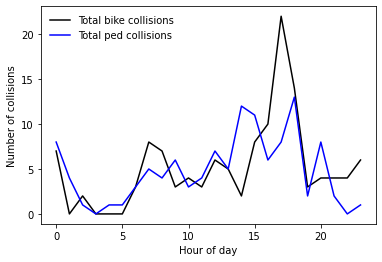

In [ ]:
hourly_collisions_bike = all_segments.sum().loc[['Total bike collisions - hour {0}'.format(hour) for hour in np.arange(24)]]
hourly_collisions_ped = all_segments.sum().loc[['Total ped collisions - hour {0}'.format(hour) for hour in np.arange(24)]]

plt.plot(np.arange(24),hourly_collisions_bike.values,c='k',label='Total bike collisions')
plt.plot(np.arange(24),hourly_collisions_ped.values,c='b',label='Total ped collisions')
plt.legend(frameon=False)
plt.xlabel('Hour of day')
plt.ylabel('Number of collisions')

## Export 12th Ave segments data to CSV file, or import from existing CSV file

In [ ]:
# Export
all_segments.to_csv(export_processed_data_filepath)

In [ ]:
# Import
all_segments = pd.read_csv(export_processed_data_filepath,
                           converters={'SDOT N intersection': lambda x: x.strip("[]").replace("'","").split(", "),
                                       'SDOT blocks': lambda x: x.strip("[]").replace("'","").split(", ")})

## Compare WSDOT manual bike counts with StreetLight output


Are all counts on weekdays, not weekends?
>  True 

AM - WSDOT counts: [84.5, 84.0, 82.0]
AM - StreetLight volumes: [89.5, 77.875, 68.5]
PM - WSDOT counts: [104.5, 78.0, 63.5]
PM - StreetLight volumes: [171.125, 137.75, 88.0]


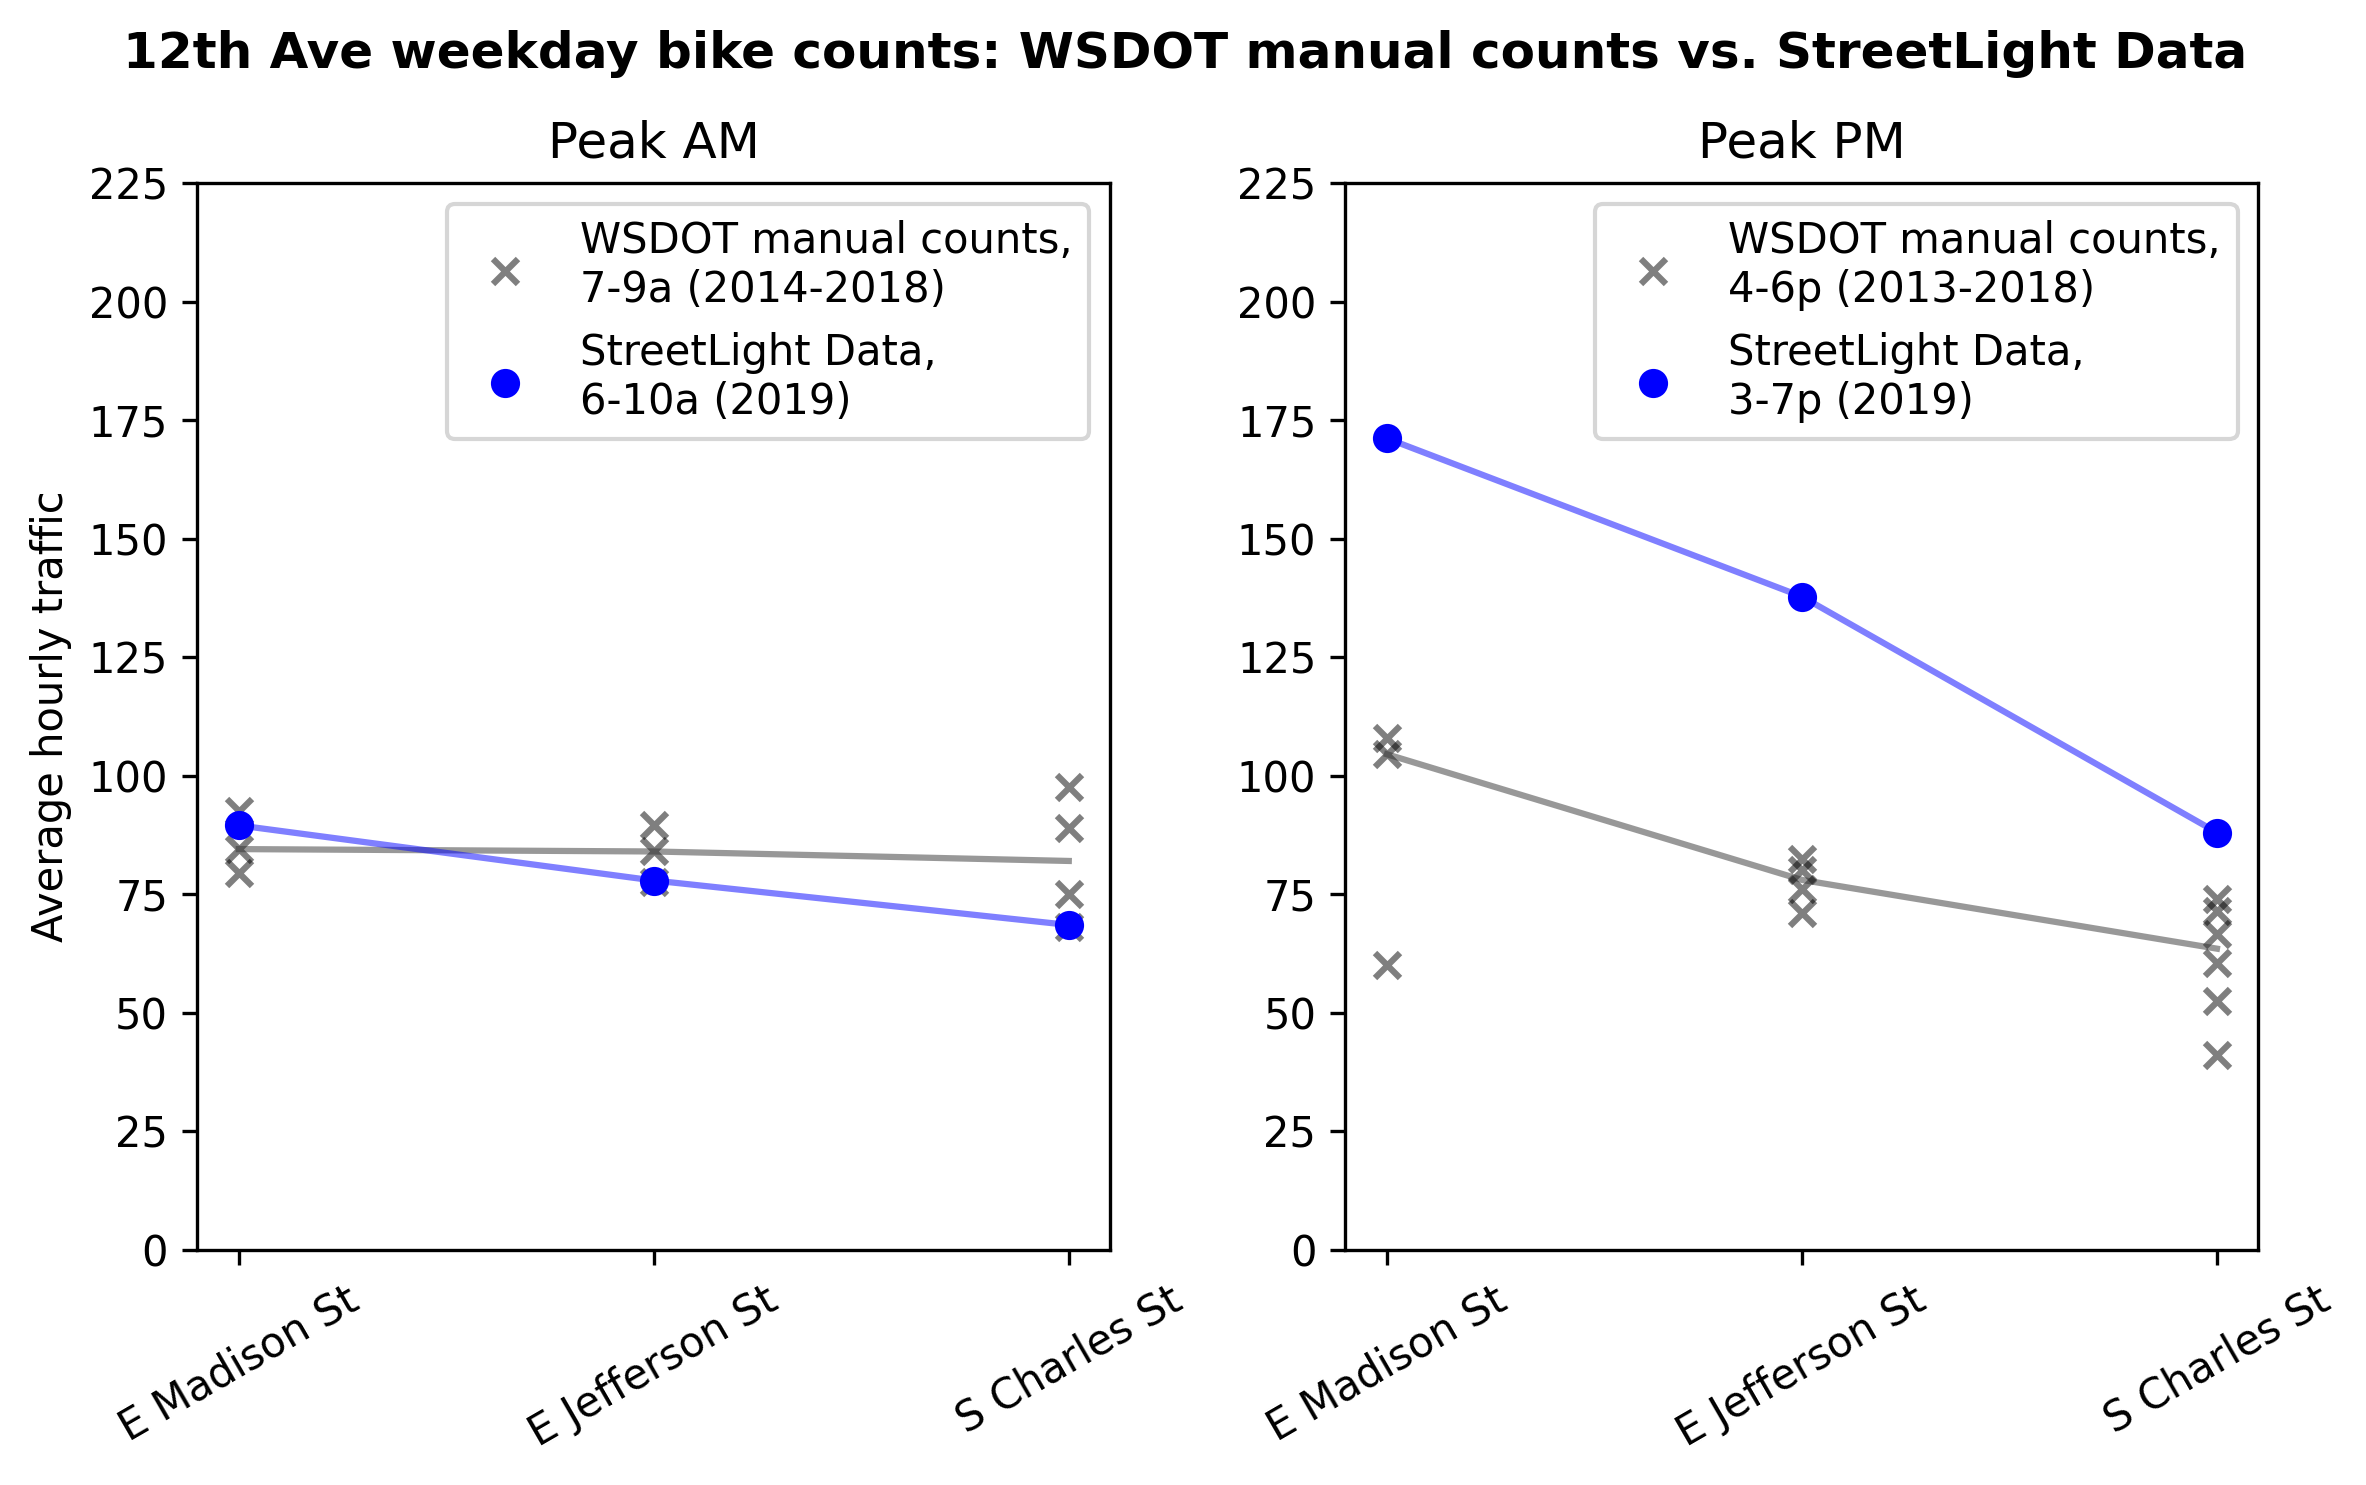

In [ ]:
# 12th Ave count locations (intersections) [column name: LocationID]
wsdot_dict = {'Seattle43':['E Madison St',[11,12]],
              'Seattle48':['E Jefferson St',[16,17]],
              'Seattle9':['S Charles St',[27]]}     # I-90 Trail and Jose Rizal Bridge

# Process data
# NOTE: excluded counts with missing dates, because couldn't verify whether weekday or weekend
# NOTE: only used data through 2019 to avoid comparing with pandemic
wsdot_counts['Bike_Total_NB_SB'] = wsdot_counts['Bike_North'] + wsdot_counts['Bike_South']
wsdot_counts_sub = \
  wsdot_counts[np.logical_or.reduce([wsdot_counts['LocationID'] == 'Seattle43',
                                     wsdot_counts['LocationID'] == 'Seattle48',
                                     wsdot_counts['LocationID'] == 'Seattle9'])]
wsdot_counts_sub = wsdot_counts_sub.sort_values(['LocationID','CountYear'])
wsdot_counts_sub = wsdot_counts_sub[['LocationID','CountYear','CountTime','CountDate',
                                     'Bike_North','Bike_South','Bike_Total_NB_SB','TimeSlot']]
wsdot_counts_sub = wsdot_counts_sub[~pd.isnull(wsdot_counts_sub['CountDate'])]
wsdot_counts_sub = wsdot_counts_sub[wsdot_counts_sub['CountYear'] <= 2019]
wsdot_counts_sub = wsdot_counts_sub.groupby(['LocationID','CountYear','CountTime',
                                             'CountDate']).sum().reset_index()

# Weekday check
print('Are all counts on weekdays, not weekends?')
print('> ',np.all(wsdot_counts_sub['CountDate'].dt.dayofweek <= 4),'\n')

# Plot parameters
count_times = ['AM','PM']
time_labels = ['Peak AM',
               'Peak PM']
wsdot_time_str = ['7-9a','4-6p']
stli_time_str = ['6-10a','3-7p']
stli_time_labels = ['2: Peak AM (6am-10am)','4: Peak PM (3pm-7pm)']
stli_day_label = '1: Weekdays (M-F)'
wsdot_year_range = [[wsdot_counts_sub[wsdot_counts_sub['CountTime'] == 'AM']['CountYear'].min(),
                     wsdot_counts_sub[wsdot_counts_sub['CountTime'] == 'AM']['CountYear'].max()],
                    [wsdot_counts_sub[wsdot_counts_sub['CountTime'] == 'PM']['CountYear'].min(),
                     wsdot_counts_sub[wsdot_counts_sub['CountTime'] == 'PM']['CountYear'].max()]]
wsdot_year_str = ['({0}-{1})'.format(*wyr) for wyr in wsdot_year_range]

# Plot
plt.figure(figsize=(8,5),dpi=300)
for time_idx, time in enumerate(count_times):
  plt.subplot(1,2,time_idx+1)
  wsdot_aht_all = []
  stli_aht_all = []
  for loc_idx, wsdot_id in enumerate(wsdot_dict.keys()):
    wsdot_totals = wsdot_counts_sub[np.logical_and(wsdot_counts_sub['LocationID'] == wsdot_id,
                                                   wsdot_counts_sub['CountTime'] == time)]
    wsdot_totals = wsdot_totals['Bike_Total_NB_SB'].values
    stli_counts = []
    for block_idx, stli_block_idx in enumerate(wsdot_dict[wsdot_id][1]):
      stli_zone_name = all_segments.loc[stli_block_idx,'StreetLight zones (bike/ped)']
      stli_time_label = stli_time_labels[time_idx]
      stli_count = stli_bike_2019.loc[np.logical_and.reduce((stli_bike_2019['Zone Name'] == stli_zone_name,
                                                             stli_bike_2019['Day Type'] == stli_day_label,
                                                             stli_bike_2019['Day Part'] == stli_time_label)),
                                      ADT_bike_ped].values[0]
      stli_counts.append(stli_count)
    stli_count_at_intersection = np.mean(stli_counts)

    # Normalize to hourly counts
    # (because WSDOT totals are from 7-9a / 4-6p = 2 hours each,
    #  and StreetLight totals are from 6-10a / 3-7p = 4 hours each)
    wsdot_aht = wsdot_totals / 2.0
    stli_aht = stli_count_at_intersection / 4.0
    wsdot_aht_all.append(np.median(wsdot_aht))
    stli_aht_all.append(stli_aht)

    if loc_idx == 0:
      wsdot_leg = 'WSDOT manual counts,\n{0} {1}'.format(wsdot_time_str[time_idx],
                                                         wsdot_year_str[time_idx])
      stli_leg = 'StreetLight Data,\n{0} (2019)'.format(stli_time_str[time_idx])
    else:
      wsdot_leg = None; stli_leg = None
    plt.scatter(np.tile(loc_idx,len(wsdot_aht)),wsdot_aht,
                c='k',marker='x',alpha=0.5,
                label=wsdot_leg)
    plt.scatter(loc_idx,stli_aht,c='b',marker='o',
                label=stli_leg)
  plt.plot([0,1,2],wsdot_aht_all,c='0.2',alpha=0.5)
  plt.plot([0,1,2],stli_aht_all,c='b',alpha=0.5)
  plt.ylim([0,225])
  plt.title(time_labels[time_idx])
  plt.legend(frameon=True,loc='upper right')
  plt.xticks([0,1,2],labels=[wsdot_dict[id][0] for id in wsdot_dict.keys()],
             rotation=30)
  if time_idx == 0: plt.ylabel('Average hourly traffic')

  # Print
  print(time,'- WSDOT counts:',wsdot_aht_all)
  print(time,'- StreetLight volumes:',stli_aht_all)

# plt.subplots_adjust(top=0.85)
plt.suptitle('12th Ave weekday bike counts: WSDOT manual counts vs. StreetLight Data',weight='bold')
plt.tight_layout(rect=(0,0,1,0.95))
plt.savefig(root + '2022-08-23 - 12th Ave WSDOT manual counts vs. StreetLight.pdf',
            bbox_inches='tight')

## Plotting

/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


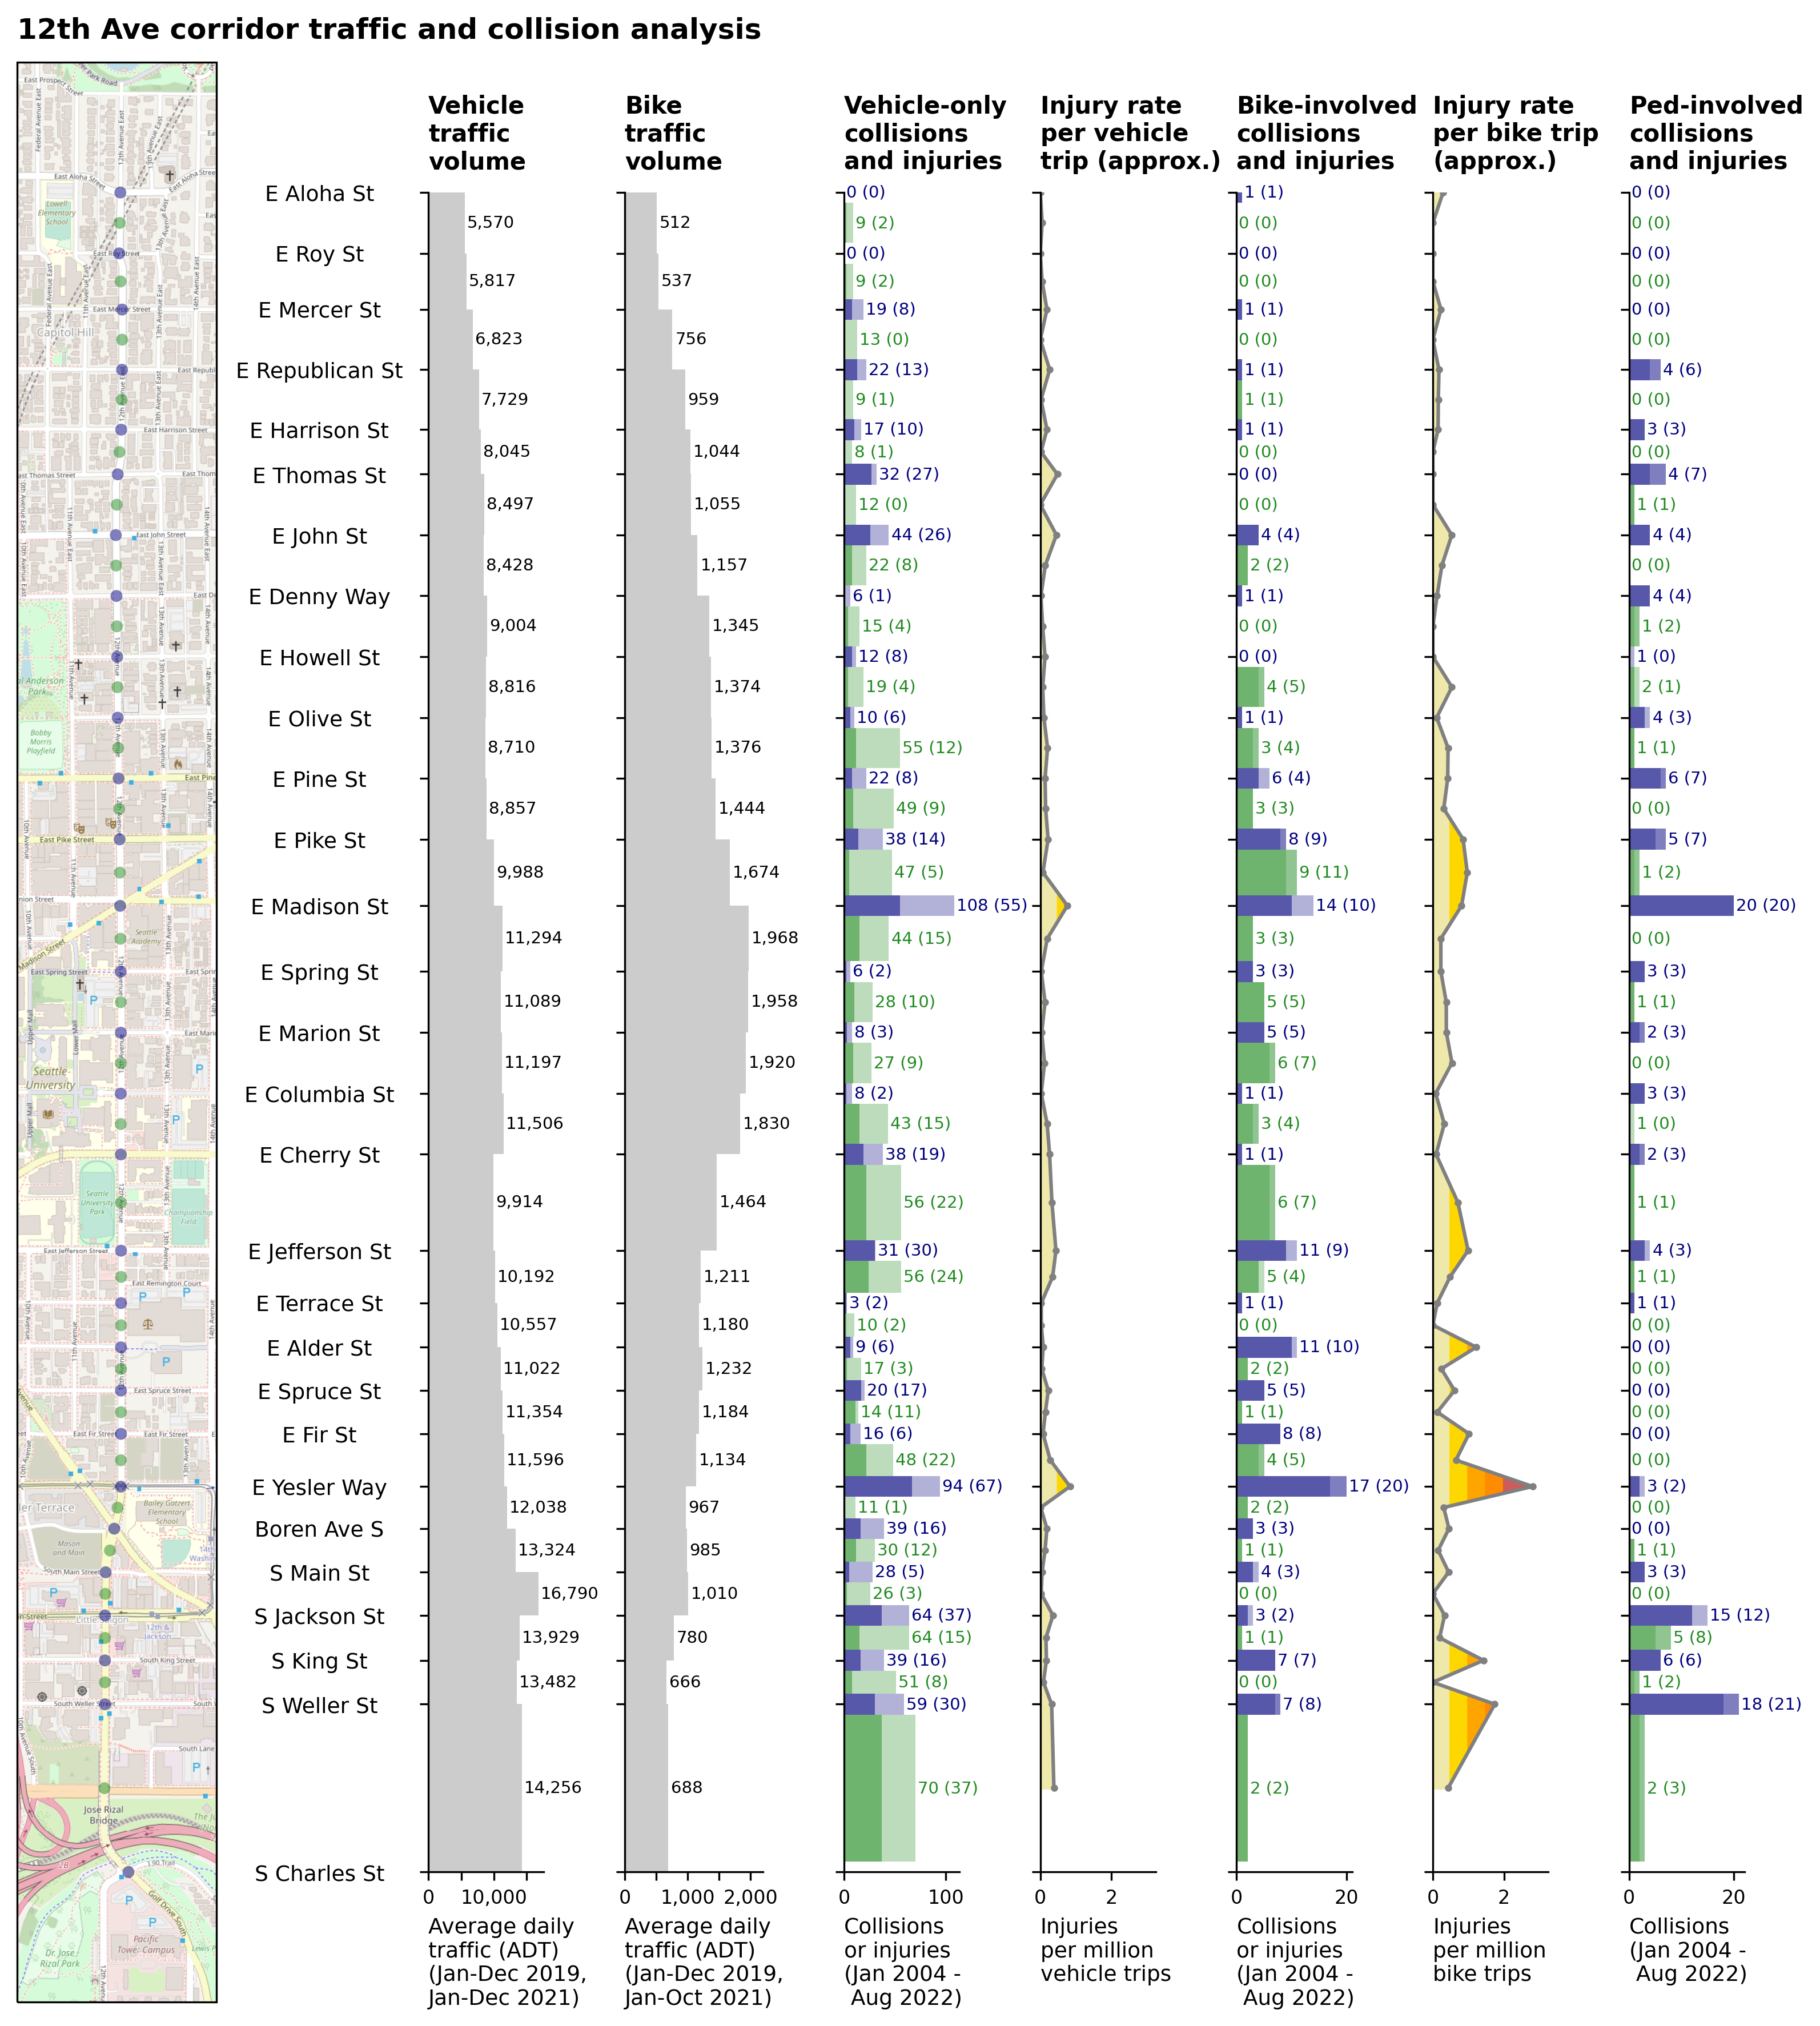

In [ ]:
all_intersection_names = np.append(all_segments['N street'].values,
                                   all_segments['S street'].values[-1])
all_intersection_names_formal \
  = np.array([street_dict_correct[name] for name in all_intersection_names])

all_intersection_lon = np.append(all_segments['N street longitude'].values,
                                 all_segments['S street longitude'].values[-1])
all_intersection_lat = np.append(all_segments['N street latitude'].values,
                                 all_segments['S street latitude'].values[-1])
all_lon_midpoints = (all_intersection_lon[1:] + all_intersection_lon[:-1]) / 2
all_lon_midpoints[-1] -= 0.00035    # manually edit Weller-Charles midpoint due to curve
all_lat_midpoints = (all_intersection_lat[1:] + all_intersection_lat[:-1]) / 2
all_lat_widths = all_segments['N street latitude'].values - \
                 all_segments['S street latitude'].values
lat_min_height = 0.0002

all_lat_combined = np.vstack([all_segments['N street latitude'],
                              all_lat_midpoints]).T.flatten()

lat_high_res = np.linspace(all_lat_combined.max(),all_lat_combined.min(),10000)

W_lon_seg = all_segments[['N street longitude','S street longitude']].min().min()
E_lon_seg = all_segments[['N street longitude','S street longitude']].max().max()
N_lat_seg = all_segments['N street latitude'].max()
S_lat_seg = all_segments['S street latitude'].min()
lon_buffer = 0.0025
lat_buffer = 0.0025
lat_extent_total = N_lat_seg - S_lat_seg + (2 * lat_buffer)

collision_period_days = (collision_end_date - collision_start_date).days

imagery = OSM()

fig = plt.figure(figsize=(14,15),dpi=300)
spec = gridspec.GridSpec(ncols=8,nrows=1,
                         width_ratios=[4,1,1.2,1,1,1,1,1],wspace=0.5)

# SUBPLOT 0: 12th Ave imagery
ax0 = plt.subplot(spec[0],projection=imagery.crs)
ax0.set_extent([W_lon_seg-lon_buffer, E_lon_seg+lon_buffer,
                S_lat_seg-lat_buffer, N_lat_seg+lat_buffer],
               ccrs.PlateCarree())
# note: 16 is the OSM zoom level: https://wiki.openstreetmap.org/wiki/Zoom_levels
ax0.add_image(imagery,16,alpha=0.75)
W_lon_map,E_lon_map,S_lat_map,N_lat_map = ax0.get_extent(crs=ccrs.PlateCarree())
for street_idx, lat in enumerate(all_intersection_lat):
  ax0.scatter(all_intersection_lon[street_idx],all_intersection_lat[street_idx],
              transform=ccrs.PlateCarree(),s=25,c='navy',marker='o',
              edgecolors='none',alpha=0.5)
  if street_idx < len(all_intersection_lat)-1:
    ax0.scatter(all_lon_midpoints[street_idx],all_lat_midpoints[street_idx],
                transform=ccrs.PlateCarree(),s=25,c='forestgreen',marker='o',
                edgecolors='none',alpha=0.5)
ax0.set_title('12th Ave corridor traffic and collision analysis',
              pad=10,fontsize=12,weight='bold',loc='left')

def config_ax(idx,title=None,xlabel=None,yticks=False):
  ax = plt.subplot(spec[idx])
  ax.axis('off')
  ax_in = ax.inset_axes([0.0, lat_buffer/lat_extent_total,
                         1.0, (N_lat_seg - S_lat_seg)/lat_extent_total])
  ax_in.set_ylim([S_lat_seg,N_lat_seg])
  ax_in.set_yticks(all_intersection_lat)
  if yticks: ax_in.set_yticklabels(all_intersection_names_formal,
                                   fontsize=9,ha='center',x=-0.8)
  else:      ax_in.tick_params(axis='y',which='both',left=True,labelleft=False)
  ax_in.tick_params(axis='x',which='both',labelsize=8)
  ax_in.spines['top'].set_visible(False)
  ax_in.spines['right'].set_visible(False)
  ax_in.set_title(title,loc='left',pad=10,fontsize=10,weight='bold')
  ax_in.set_xlabel(xlabel,x=0.0,horizontalalignment='left',fontsize=9)
  return ax_in

def add_numbers(ax,lats,col_label,second_col_label=None,color='k'):
  for street_idx, lat in enumerate(lats):
    text_str = '{:,}'.format(int(round(all_segments.loc[street_idx,col_label])))
    if second_col_label is not None:
      text_str += ' ({:,})'.format(int(round(all_segments.loc[street_idx,second_col_label])))
    baseline_x = all_segments.loc[street_idx,col_label]
    if second_col_label is not None:
      baseline_x = np.max([baseline_x,all_segments.loc[street_idx,second_col_label]])
    ax.text(baseline_x+ax.get_xlim()[1]*0.02,lat,
            text_str,fontsize=7,ha='left',va='center',color=color)

# SUBPLOT 1: Vehicle traffic volume
ax1_in = config_ax(1,title='Vehicle\ntraffic\nvolume',
                   xlabel='Average daily\ntraffic (ADT)\n(Jan-Dec 2019,\nJan-Dec 2021)',yticks=True)
ax1_in.barh(all_lat_midpoints,all_segments['StreetLight ADT vehicle total (combined)'],
            height=all_lat_widths*1.0,color='0.8')
ax1_in.set_xticks([0,5000,10000,15000])
ax1_in.set_xticklabels(['0','','10,000',''])
add_numbers(ax1_in,all_lat_midpoints,'StreetLight ADT vehicle total (combined)')

# SUBPLOT 2: Bike traffic volume
ax2_in = config_ax(2,title='Bike\ntraffic\nvolume',
                   xlabel='Average daily\ntraffic (ADT)\n(Jan-Dec 2019,\nJan-Oct 2021)')
ax2_in.barh(all_lat_midpoints,all_segments['StreetLight ADT bike (combined)'],
            height=all_lat_widths*1.0,color='0.8')
ax2_in.set_xlim([0,2200])
ax2_in.set_xticks([0,500,1000,1500,2000])
ax2_in.set_xticklabels(['0','','1,000','','2,000'])
add_numbers(ax2_in,all_lat_midpoints,'StreetLight ADT bike (combined)')

# SUBPLOT 3: Vehicle-only collisions and injuries
ax3_in = config_ax(3,title='Vehicle-only\ncollisions\nand injuries',
                   xlabel='Collisions\nor injuries\n({0} -\n {1})'\
                          .format(collision_start_date.strftime('%b %Y'),
                                  collision_end_date.strftime('%b %Y')))
ax3_in.barh(all_lat_midpoints,all_segments['Midblock vehicle-only collisions'],
            height=all_lat_widths-(2*lat_min_height),color='forestgreen',alpha=0.3)
ax3_in.barh(all_lat_midpoints,all_segments['Midblock vehicle-only injuries'],
            height=all_lat_widths-(2*lat_min_height),color='forestgreen',alpha=0.5)
ax3_in.barh(all_segments['N street latitude'],
            all_segments['N intersection vehicle-only collisions'],
            height=2*lat_min_height,color='navy',alpha=0.3)
ax3_in.barh(all_segments['N street latitude'],
            all_segments['N intersection vehicle-only injuries'],
            height=2*lat_min_height,color='navy',alpha=0.5)
add_numbers(ax3_in,all_lat_midpoints,
            'Midblock vehicle-only collisions',
            second_col_label='Midblock vehicle-only injuries',
            color='forestgreen')
add_numbers(ax3_in,all_segments['N street latitude'],
            'N intersection vehicle-only collisions',
            second_col_label='N intersection vehicle-only injuries',
            color='navy')

# SUBPLOT 4: Injuries per vehicle trip
ax4_in = config_ax(4,title='Injury rate\nper vehicle\ntrip (approx.)',
                   xlabel='Injuries\nper million\nvehicle trips')
traffic_veh = all_segments['StreetLight ADT vehicle total (combined)'].values
traffic_midpoints_veh = np.append(traffic_veh[0],
                                  (traffic_veh[1:] + traffic_veh[:-1]) / 2)
traffic_combined_veh = np.vstack([traffic_midpoints_veh,traffic_veh]).T.flatten()
injuries_combined_veh \
  = np.vstack([all_segments['N intersection vehicle-only injuries'],
               all_segments['Midblock vehicle-only injuries']]).T.flatten()
injuries_scaled_veh = 1000000 * \
  (injuries_combined_veh / collision_period_days) / traffic_combined_veh
interpolant_veh = interp1d(all_lat_combined,injuries_scaled_veh)
injuries_scaled_veh_high_res = interpolant_veh(lat_high_res)
ax4_in.fill_betweenx(lat_high_res,np.minimum(injuries_scaled_veh_high_res,0.5),
                     color='palegoldenrod')
ax4_in.fill_betweenx(lat_high_res,np.minimum(injuries_scaled_veh_high_res,1.0),
                     x2=0.5,where=injuries_scaled_veh_high_res>0.5,color='gold')
ax4_in.fill_betweenx(lat_high_res,np.minimum(injuries_scaled_veh_high_res,1.5),
                     x2=1.0,where=injuries_scaled_veh_high_res>1.0,color='orange')
ax4_in.fill_betweenx(lat_high_res,np.minimum(injuries_scaled_veh_high_res,2.0),
                     x2=1.5,where=injuries_scaled_veh_high_res>1.5,color='darkorange')
ax4_in.fill_betweenx(lat_high_res,injuries_scaled_veh_high_res,
                     x2=2.0,where=injuries_scaled_veh_high_res>2.0,color='indianred')
ax4_in.plot(injuries_scaled_veh,all_lat_combined,c='0.5',marker='o',ms=2)
ax4_in.set_xlim([0,3.25])

# SUBPLOT 5: Bike-involved collisions and injuries
ax5_in = config_ax(5,title='Bike-involved\ncollisions\nand injuries',
                   xlabel='Collisions\nor injuries\n({0} -\n {1})'\
                          .format(collision_start_date.strftime('%b %Y'),
                                  collision_end_date.strftime('%b %Y')))
ax5_in.barh(all_lat_midpoints,all_segments['Midblock bike collisions'],
            height=all_lat_widths-(2*lat_min_height),color='forestgreen',alpha=0.3)
ax5_in.barh(all_lat_midpoints,all_segments['Midblock bike injuries'],
            height=all_lat_widths-(2*lat_min_height),color='forestgreen',alpha=0.5)
ax5_in.barh(all_segments['N street latitude'],
            all_segments['N intersection bike collisions'],
            height=2*lat_min_height,color='navy',alpha=0.3)
ax5_in.barh(all_segments['N street latitude'],
            all_segments['N intersection bike injuries'],
            height=2*lat_min_height,color='navy',alpha=0.5)
add_numbers(ax5_in,all_lat_midpoints,
            'Midblock bike collisions',
            second_col_label='Midblock bike injuries',
            color='forestgreen')
add_numbers(ax5_in,all_segments['N street latitude'],
            'N intersection bike collisions',
            second_col_label='N intersection bike injuries',
            color='navy')

# SUBPLOT 6: Injuries per bike trip
ax6_in = config_ax(6,title='Injury rate\nper bike trip\n(approx.)',
                   xlabel='Injuries\nper million\nbike trips')
traffic_bike = all_segments['StreetLight ADT bike (combined)'].values
traffic_midpoints_bike = np.append(traffic_bike[0],
                                  (traffic_bike[1:] + traffic_bike[:-1]) / 2)
traffic_combined_bike = np.vstack([traffic_midpoints_bike,traffic_bike]).T.flatten()
injuries_combined_bike \
  = np.vstack([all_segments['N intersection bike injuries'],
               all_segments['Midblock bike injuries']]).T.flatten()
injuries_scaled_bike = 1000000 * \
  (injuries_combined_bike / collision_period_days) / traffic_combined_bike
interpolant_bike = interp1d(all_lat_combined,injuries_scaled_bike)
injuries_scaled_bike_high_res = interpolant_bike(lat_high_res)
ax6_in.fill_betweenx(lat_high_res,np.minimum(injuries_scaled_bike_high_res,0.5),
                     color='palegoldenrod')
ax6_in.fill_betweenx(lat_high_res,np.minimum(injuries_scaled_bike_high_res,1.0),
                     x2=0.5,where=injuries_scaled_bike_high_res>0.5,color='gold')
ax6_in.fill_betweenx(lat_high_res,np.minimum(injuries_scaled_bike_high_res,1.5),
                     x2=1.0,where=injuries_scaled_bike_high_res>1.0,color='orange')
ax6_in.fill_betweenx(lat_high_res,np.minimum(injuries_scaled_bike_high_res,2.0),
                     x2=1.5,where=injuries_scaled_bike_high_res>1.5,color='darkorange')
ax6_in.fill_betweenx(lat_high_res,injuries_scaled_bike_high_res,
                     x2=2.0,where=injuries_scaled_bike_high_res>2.0,color='indianred')
ax6_in.plot(injuries_scaled_bike,all_lat_combined,c='0.5',marker='o',ms=2)
ax6_in.set_xlim([0,3.25])

# SUBPLOT 7: Ped-involved collisions and injuries
ax7_in = config_ax(7,title='Ped-involved\ncollisions\nand injuries',
                   xlabel='Collisions\n({0} -\n {1})'\
                          .format(collision_start_date.strftime('%b %Y'),
                                  collision_end_date.strftime('%b %Y')))
ax7_in.barh(all_lat_midpoints,all_segments['Midblock ped collisions'],
            height=all_lat_widths-(2*lat_min_height),color='forestgreen',alpha=0.3)
ax7_in.barh(all_lat_midpoints,all_segments['Midblock ped injuries'],
            height=all_lat_widths-(2*lat_min_height),color='forestgreen',alpha=0.5)
ax7_in.barh(all_segments['N street latitude'],
            all_segments['N intersection ped collisions'],
            height=2*lat_min_height,color='navy',alpha=0.3)
ax7_in.barh(all_segments['N street latitude'],
            all_segments['N intersection ped injuries'],
            height=2*lat_min_height,color='navy',alpha=0.5)
add_numbers(ax7_in,all_lat_midpoints,
            'Midblock ped collisions',
            second_col_label='Midblock ped injuries',
            color='forestgreen')
add_numbers(ax7_in,all_segments['N street latitude'],
            'N intersection ped collisions',
            second_col_label='N intersection ped injuries',
            color='navy')

plt.savefig(root + '2022-08-21 - 12th Ave corridor traffic and collision analysis.pdf',
            bbox_inches='tight')

## Summary statistics

In [ ]:
print('[1] Stefanie''s bike/ped-only data set')
print('Number of entries:',len(data))
print('Date range: 2016-2020')

print('\n[2] SDOT raw data set:')
print('Number of entries (incl. vehicle-only collisions, some outside corridor):',len(curated_data_incl_vehicles))
print('Number of entries (bike/ped-only):',len(curated_data))
print('Date range (bike/ped-only): {0}-{1}'.format(curated_data['INCDTTM'].dt.year.min(),
                                                   curated_data['INCDTTM'].dt.year.max()))

[1] Stefanies bike/ped-only data set
Number of entries: 72
Date range: 2016-2020

[2] SDOT raw data set:
Number of entries (incl. vehicle-only collisions, some outside corridor): 2216
Number of entries (bike/ped-only): 329
Date range (bike/ped-only): 2004-2021


## Analysis of records from SDOT raw data set

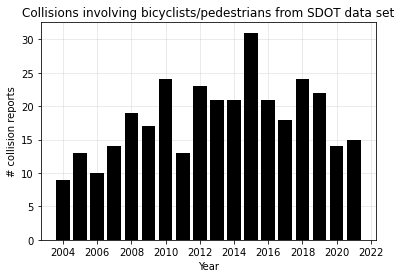

In [ ]:
plt.figure(facecolor='w')
years = curated_data['INCDTTM'].dt.year
plt.hist(years,bins=np.arange(years.min(),years.max()+2,1)-0.5,color='k',zorder=2,rwidth=0.8);
plt.xticks(np.arange(years.min(),years.max()+2,2))
plt.ylabel('# collision reports')
plt.xlabel('Year');
plt.grid(lw=0.5,alpha=0.5,zorder=1)
plt.title('Collisions involving bicyclists/pedestrians from SDOT data set');

### Top locations for bike/ped collisions at intersections

In [ ]:
curated_data['LOCATION'].loc[curated_data['JUNCTIONTYPE'] == 'At Intersection (intersection related)'].value_counts()

12TH AVE AND E MADISON ST         34
12TH AVE S AND S WELLER ST        25
12TH AVE AND E YESLER WAY         19
12TH AVE S AND S JACKSON ST       18
12TH AVE AND E JEFFERSON ST       15
12TH AVE AND E PIKE ST            13
12TH AVE S AND S KING ST          13
12TH AVE AND E PINE ST            12
12TH AVE AND E ALDER ST           11
12TH AVE AND E FIR ST              8
12TH AVE E AND E JOHN ST           8
12TH AVE AND E MARION ST           7
12TH AVE S AND S MAIN ST           7
12TH AVE AND E SPRING ST           6
12TH AVE AND E OLIVE ST            5
12TH AVE AND E DENNY WAY           5
12TH AVE E AND E REPUBLICAN ST     5
12TH AVE AND E SPRUCE ST           5
12TH AVE E AND E THOMAS ST         4
12TH AVE E AND E HARRISON ST       4
12TH AVE AND E COLUMBIA ST         4
12TH AVE AND E CHERRY ST           3
12TH AVE S AND BOREN AVE S         3
12TH AVE AND E TERRACE ST          2
12TH AVE S AND S CLOVERDALE ST     2
12TH AVE AND E BARCLAY CT          1
12TH AVE S AND S SHELTON ST        1
1

In [ ]:
print('Top intersections by bike/ped collisions (2017-2021 only):')
curated_data['LOCATION'].loc[np.logical_and(curated_data['JUNCTIONTYPE'] == 'At Intersection (intersection related)',
                                            curated_data['INCDTTM'].dt.year >= 2017)].value_counts()

Top intersections by bike/ped collisions (2017-2021 only):


12TH AVE AND E YESLER WAY         10
12TH AVE S AND S WELLER ST         8
12TH AVE S AND S KING ST           6
12TH AVE AND E MADISON ST          5
12TH AVE AND E FIR ST              4
12TH AVE AND E PIKE ST             4
12TH AVE AND E PINE ST             4
12TH AVE AND E MARION ST           4
12TH AVE AND E ALDER ST            4
12TH AVE AND E OLIVE ST            3
12TH AVE AND E COLUMBIA ST         3
12TH AVE AND E JEFFERSON ST        3
12TH AVE AND E SPRUCE ST           2
12TH AVE E AND E HARRISON ST       2
12TH AVE AND E SPRING ST           2
12TH AVE S AND S MAIN ST           2
12TH AVE E AND E JOHN ST           2
12TH AVE S AND S JACKSON ST        2
12TH AVE W AND GILMAN DR W         1
12TH AVE S AND S CLOVERDALE ST     1
12TH AVE AND E DENNY WAY           1
12TH AVE AND E CHERRY ST           1
12TH AVE S AND S CHARLES S ST      1
12TH AVE E AND E ALOHA ST          1
12TH AVE E AND E REPUBLICAN ST     1
12TH AVE E AND E THOMAS ST         1
Name: LOCATION, dtype: int64

### Top locations for bike/ped collisions at intersections (injuries recorded as "serious" only)

In [ ]:
curated_data['LOCATION'].loc[np.logical_and(curated_data['JUNCTIONTYPE'] == 'At Intersection (intersection related)',
                                            curated_data['SERIOUSINJURIES'] > 0)].value_counts()

12TH AVE S AND S WELLER ST        3
12TH AVE AND E PIKE ST            3
12TH AVE E AND E REPUBLICAN ST    2
12TH AVE AND E YESLER WAY         2
12TH AVE S AND S KING ST          1
12TH AVE AND E JEFFERSON ST       1
12TH AVE AND E CHERRY ST          1
12TH AVE S AND S JACKSON ST       1
12TH AVE AND E PINE ST            1
12TH AVE S AND S CHARLES S ST     1
12TH AVE AND E OLIVE ST           1
Name: LOCATION, dtype: int64

### Collisions at specific intersections over time

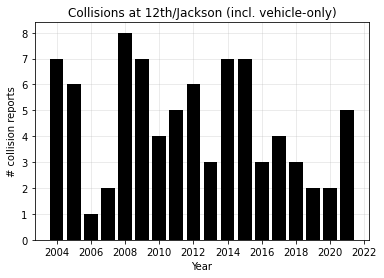

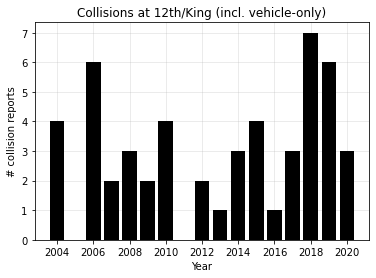

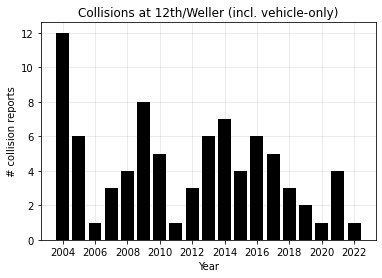

In [ ]:
years = curated_data_incl_vehicles['INCDTTM'].loc[curated_data_incl_vehicles['LOCATION'] == '12TH AVE S AND S JACKSON ST'].dt.year
plt.figure(facecolor='w')
plt.hist(years,bins=np.arange(years.min(),years.max()+2,1)-0.5,color='k',zorder=2,rwidth=0.8);
plt.xticks(np.arange(years.min(),years.max()+2,2))
plt.ylabel('# collision reports')
plt.xlabel('Year');
plt.grid(lw=0.5,alpha=0.5,zorder=1)
plt.title('Collisions at 12th/Jackson (incl. vehicle-only)');

years = curated_data_incl_vehicles['INCDTTM'].loc[curated_data_incl_vehicles['LOCATION'] == '12TH AVE S AND S KING ST'].dt.year
plt.figure(facecolor='w')
plt.hist(years,bins=np.arange(years.min(),years.max()+2,1)-0.5,color='k',zorder=2,rwidth=0.8);
plt.xticks(np.arange(years.min(),years.max()+2,2))
plt.ylabel('# collision reports')
plt.xlabel('Year');
plt.grid(lw=0.5,alpha=0.5,zorder=1)
plt.title('Collisions at 12th/King (incl. vehicle-only)');

years = curated_data_incl_vehicles['INCDTTM'].loc[curated_data_incl_vehicles['LOCATION'] == '12TH AVE S AND S WELLER ST'].dt.year
plt.figure(facecolor='w')
plt.hist(years,bins=np.arange(years.min(),years.max()+2,1)-0.5,color='k',zorder=2,rwidth=0.8);
plt.xticks(np.arange(years.min(),years.max()+2,2))
plt.ylabel('# collision reports')
plt.xlabel('Year');
plt.grid(lw=0.5,alpha=0.5,zorder=1)
plt.title('Collisions at 12th/Weller (incl. vehicle-only)');

## Analysis of records from Stefanie's 2016-2020 data set

In [ ]:
data['MOST SEVERE INJURY TYPE'].value_counts(normalize=True) * 100

Possible Injury             43.283582
Suspected Minor Injury      35.820896
Suspected Serious Injury    14.925373
No Apparent Injury           4.477612
Unknown                      1.492537
Name: MOST SEVERE INJURY TYPE, dtype: float64

In [ ]:
data['JUNCTION RELATIONSHIP'].value_counts(normalize=True) * 100

At Intersection and Related            68.656716
Not at Intersection and Not Related    26.865672
At Driveway                             2.985075
At Intersection and Not Related         1.492537
Name: JUNCTION RELATIONSHIP, dtype: float64

In [ ]:
data['LIGHTING CONDITION'].value_counts(normalize=True) * 100

Daylight                  62.686567
Dark-Street Lights On     26.865672
Dusk                       5.970149
Dawn                       2.985075
Dark - Unknown Lightin     1.492537
Name: LIGHTING CONDITION, dtype: float64

In [ ]:
data['ROADWAY SURFACE CONDITION'].value_counts(normalize=True) * 100

Dry    80.597015
Wet    19.402985
Name: ROADWAY SURFACE CONDITION, dtype: float64

In [ ]:
data['FIRST COLLISION TYPE / OBJECT STRUCK'].value_counts(normalize=True) * 100

Vehicle - Pedalcyclist                                    37.313433
Vehicle Strikes Pedalcyclist                              22.388060
Vehicle going straight hits pedestrian                    17.910448
Vehicle turning left hits pedestrian                       8.955224
Pedalcyclist Strikes Moving Vehicle                        5.970149
From opposite direction - one left turn - one straight     2.985075
Vehicle turning right hits pedestrian                      2.985075
Vehicle hits Pedestrian - All Other Actions                1.492537
Name: FIRST COLLISION TYPE / OBJECT STRUCK, dtype: float64

In [ ]:
data['VEHICLE 1 ACTION'].value_counts(normalize=True) * 100

# 52% making turns

Making Left Turn                 39.682540
Going Straight Ahead             28.571429
Making Right Turn                12.698413
Changing Lanes                    6.349206
Stopped in Roadway                4.761905
Starting From Parked Position     3.174603
Legally Parked, Occupied          3.174603
Making U-Turn                     1.587302
Name: VEHICLE 1 ACTION, dtype: float64

In [ ]:
data['VEHICLE 1 COMPASS DIRECTION FROM'].value_counts(normalize=True) * 100

South              45.000000
North              38.333333
East                8.333333
Vehicle Stopped     5.000000
West                3.333333
Name: VEHICLE 1 COMPASS DIRECTION FROM, dtype: float64

In [ ]:
data['VEHICLE 1 COMPASS DIRECTION TO'].value_counts(normalize=True) * 100

South              33.333333
West               33.333333
North              13.333333
East               13.333333
Vehicle Stopped     3.333333
Southwest           1.666667
Northwest           1.666667
Name: VEHICLE 1 COMPASS DIRECTION TO, dtype: float64

In [ ]:
data[['VEHICLE 1 COMPASS DIRECTION FROM','VEHICLE 1 COMPASS DIRECTION TO','# BIKES']].value_counts(normalize=True) * 100

VEHICLE 1 COMPASS DIRECTION FROM  VEHICLE 1 COMPASS DIRECTION TO  # BIKES
South                             West                            1.0        21.666667
North                             South                           0.0        15.000000
                                                                  1.0        10.000000
South                             West                            0.0         6.666667
                                  East                            1.0         6.666667
                                  North                           0.0         5.000000
North                             West                            1.0         3.333333
East                              South                           1.0         3.333333
North                             East                            1.0         3.333333
Vehicle Stopped                   Vehicle Stopped                 1.0         3.333333
East                              South                 

In [ ]:
data['MV DRIVER CONTRIBUTING CIRCUMSTANCE 1 (UNIT 1)'].value_counts(normalize=True) * 100

Inattention                           20.634921
None                                  19.047619
Did Not Grant R/W to Non Motorist     15.873016
Unknown Distraction                   12.698413
Other Contributing Circ Not Listed    11.111111
Improper Turn/Merge                    7.936508
Did Not Grant RW to Vehicle            6.349206
Disregard Flagger / Officer            1.587302
Follow Too Closely                     1.587302
Driver Not Distracted                  1.587302
Disregard Stop and Go Light            1.587302
Name: MV DRIVER CONTRIBUTING CIRCUMSTANCE 1 (UNIT 1), dtype: float64

In [ ]:
data[['VEHICLE 1 ACTION','MV DRIVER CONTRIBUTING CIRCUMSTANCE 1 (UNIT 1)']].value_counts(normalize=True) * 100

VEHICLE 1 ACTION               MV DRIVER CONTRIBUTING CIRCUMSTANCE 1 (UNIT 1)
Making Left Turn               Did Not Grant R/W to Non Motorist                 9.523810
                               Inattention                                       7.936508
Going Straight Ahead           None                                              6.349206
                               Other Contributing Circ Not Listed                6.349206
Making Left Turn               Did Not Grant RW to Vehicle                       4.761905
                               Unknown Distraction                               4.761905
                               None                                              4.761905
                               Improper Turn/Merge                               4.761905
Going Straight Ahead           Unknown Distraction                               4.761905
Stopped in Roadway             None                                              4.761905
Going Straight Ahead  

In [ ]:
data['BICYCLIST CONTRIBUTING CIRCUMSTANCE 1 (UNIT 2)'].value_counts(normalize=True) * 100

None                                  77.142857
Driver Not Distracted                  8.571429
Improper Turn/Merge                    5.714286
Other Contributing Circ Not Listed     2.857143
Did Not Grant RW to Vehicle            2.857143
Unknown Distraction                    2.857143
Name: BICYCLIST CONTRIBUTING CIRCUMSTANCE 1 (UNIT 2), dtype: float64

In [ ]:
data['PEDESTRIAN CONTRIBUTING CIRCUMSTANCE 1 (UNIT 2)'].value_counts(normalize=True) * 100

None                             57.894737
Inattention                      26.315789
Failure to Use Xwalk              5.263158
Under Influence of Alcohol        5.263158
Apparently Asleep or Fatigued     5.263158
Name: PEDESTRIAN CONTRIBUTING CIRCUMSTANCE 1 (UNIT 2), dtype: float64

In [ ]:
data['FIRST IMPACT LOCATION (City, County & Misc Trafficways - 2010 forward)'].value_counts(normalize=True) * 100

Lane of Primary Trafficway                         71.641791
Intersecting Trafficway                            16.417910
Outside Shoulder of Primary Trafficway              8.955224
Past the Outside Shoulder of Primary Trafficway     2.985075
Name: FIRST IMPACT LOCATION (City, County & Misc Trafficways - 2010 forward), dtype: float64

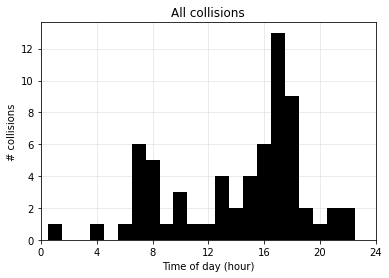

In [ ]:
plt.figure(facecolor='w')
hours = np.array([val[:2] for val in data['TIME'].astype(str) if val[:2] != 'na']).astype(int)
plt.hist(hours,bins=np.arange(24)-0.5,color='k',zorder=2);
plt.xticks(np.arange(0,25,4))
plt.xlim([0,24])
plt.ylabel('# collisions')
plt.xlabel('Time of day (hour)');
plt.grid(lw=0.5,alpha=0.5,zorder=1);
plt.title('All collisions');

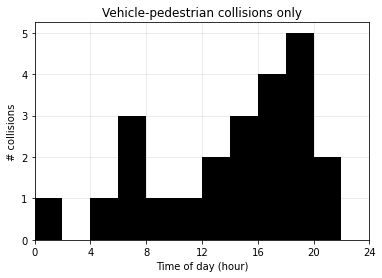

In [ ]:
ped_only = data[data['# PEDS'] > 0]
plt.figure(facecolor='w')
hours = np.array([val[:2] for val in ped_only['TIME'].astype(str) if val[:2] != 'na']).astype(int)
plt.hist(hours,bins=np.arange(1,27,2)-1,color='k',zorder=2);
plt.xticks(np.arange(0,25,4))
plt.xlim([0,24])
plt.ylabel('# collisions')
plt.xlabel('Time of day (hour)');
plt.grid(lw=0.5,alpha=0.5,zorder=1)
plt.title('Vehicle-pedestrian collisions only');

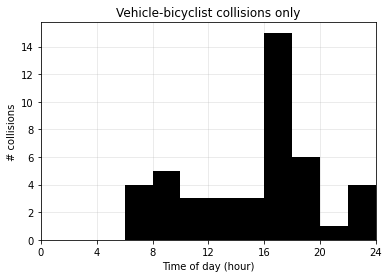

In [ ]:
bike_only = data[data['# BIKES'] > 0]
plt.figure(facecolor='w')
hours = np.array([val[:2] for val in bike_only['TIME'].astype(str) if val[:2] != 'na']).astype(int)
plt.hist(hours,bins=np.arange(1,27,2)-1,color='k',zorder=2);
plt.xticks(np.arange(0,25,4))
plt.xlim([0,24])
plt.ylabel('# collisions')
plt.xlabel('Time of day (hour)');
plt.grid(lw=0.5,alpha=0.5,zorder=1)
plt.title('Vehicle-bicyclist collisions only');

## For E Olive Way

In [ ]:
# FOR E OLIVE WAY
# Process full SDOT collision data set (run once, then ignore)
# SOURCE: https://data.seattle.gov/dataset/Collisions/fvs9-8a7k
export_data_filepath_olive = data_dir + '2022-07-21 - all E Olive Way collisions from SDOT data set.csv'
full_data = pd.read_csv(full_data_filepath,parse_dates=True,low_memory=False)
full_data.loc[full_data['LOCATION'].astype(str).str.startswith('E OLIVE WAY BETWEEN')]\
                                    .reset_index().to_csv(export_data_filepath_olive)